Lab
==========================================
Text Feature Extraction for Classification
------------------------------------------
Alessandro D. Gagliardi  
*(adapted from Olivier Grisel's tutorial)*

<style>
div.input {
    width: 105ex; /* about 80 chars + buffer */
}
div.text_cell {
    width: 105ex; /* instead of 100%, */
}
div.text_cell_render {
    /*font-family: "Helvetica Neue", Arial, Helvetica, Geneva, sans-serif;*/
    font-family: "Charis SIL", serif !important; /* Make non-code text serif. */
    line-height: 145% !important; /* added for some line spacing of text. */
    width: 105ex !important; /* instead of 'inherit' for shorter lines */
}
/* Set the size of the headers */
div.text_cell_render h1 {
    font-size: 18pt;
}
div.text_cell_render h2 {
    font-size: 14pt;
}
.CodeMirror {
     font-family: Consolas, monospace;
}
</style>

Outline of this section:

- Turn a corpus of text documents into **feature vectors** using a **Bag of Words** representation,
- Train a simple text classifier on the feature vectors,
- Wrap the vectorizer and the classifier with a **pipeline**,
- Cross-validation and **model selection** on the pipeline.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from seaborn import plt
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer


# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

In Pairs
=========

```bash
$ unzip Classification_data -d Classification_data
```

1. Load the dateset using `load_files` (hint: our `categories` are now `spam`, `easy_ham`, etc.)
2. Write a pre-processor callable to remove the message headers.
3. Set up a pipeline for cross validation and model selection using `spam` and `easy_ham`.
    - Which parameters should be optimized?
    - Do you expect the results to be different from the parameters above? Why/why not?
    - Are there other parameters we should optimize that we haven't tested?
4. Use `GridSearchCV` to find optimal parameters for vectorizor and classifier.
5. Run classifier against `hard_ham`. What percentage of `hard_ham` does it correctly identify as not `spam`?
6. Display the most discriminative features. Anything stick out?
7. Run classifier against `spam_2`, `easy_ham_2`, `hard_ham_2`. 
    - Plot the ROC curve (along with AUC) for each case. 
    - Print the confusion matrix

##1. Load the dateset using `load_files` (hint: our `categories` are now `spam`, `easy_ham`, etc.)


In [2]:
categories = [
    'spam',
    'easy_ham', 
]

train_data = load_files('datasets/no_hard_ham_train/',categories=categories, encoding='latin-1')
test_data = load_files('datasets/no_hard_ham_test/',categories=categories, encoding='latin-1')

In [3]:
#lets make sure we have the data:

all_target_names = train_data.target_names

def display_sample(i, dataset):
    print("Class name: " + dataset.target_names[dataset.target[i]])
    print("Text content:\n")
    print(dataset.data[i])

    
#display_sample(0, train_data) 

##2. Write a pre-processor callable to remove the message headers.


In [4]:


def strip_headers(post):
    """Find the first blank line and drop the headers to keep the body"""
    if '\n\n' in post:
        headers, body = post.split('\n\n', 1)
        return body.lower()
    else:
        # Unexpected post inner-structure, be conservative
        # and keep everything
        return post.lower()
    
#print strip_headers(train_data.data[0])

##3. Set up a pipeline for cross validation and model selection using `spam` and `easy_ham`.


In [5]:
#    - Which parameters should be optimized?
#    - Do you expect the results to be different from the parameters above? Why/why not?
#    - Are there other parameters we should optimize that we haven't tested?

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

strip_vectorizer = TfidfVectorizer(preprocessor=strip_headers, min_df=2)

pipeline = Pipeline((
    ('vec', strip_vectorizer),
    ('clf', MultinomialNB()),
))


##4. Use `GridSearchCV` to find optimal parameters for vectorizor and classifier.


In [63]:

from sklearn.grid_search import GridSearchCV

parameters = {
    'vec__max_df': [0.8, 1.0],
    'vec__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': np.logspace(-5, 0, 6)
}

gs = GridSearchCV(pipeline, parameters, verbose=0, refit=False, n_jobs=3)
_ = gs.fit(train_data.data, train_data.target)

In [65]:
gs.best_score_

0.99428367274026441

In [66]:
gs.best_params_

{'clf__alpha': 1.0000000000000001e-05,
 'vec__max_df': 0.8,
 'vec__ngram_range': (1, 2)}

In [6]:
#build a model using these "ideal params"

pipeline = Pipeline((
    ('vec', TfidfVectorizer(max_df = 0.8, ngram_range = (1, 2), use_idf=True, preprocessor=strip_headers)),
    ('clf', MultinomialNB(alpha = 0.00001)),
))


modelNB = pipeline.fit(train_data.data, train_data.target)

In [7]:
#run the model against the training data
modelNB.score(test_data.data, test_data.target)

0.94569489103251159

##5. Run classifier against `hard_ham`. What percentage of `hard_ham` does it correctly identify as not `spam`?


In [8]:
#load hard ham data
categories2 = ['hard_ham']
test_hard_ham = load_files('datasets/with_hard_ham_train/',categories=categories2, encoding='latin-1')

In [10]:
train_data.target_names

['easy_ham', 'spam']

In [12]:
#Show the values in a dataframe
predicted = modelNB.predict(test_hard_ham.data)
actual = test_hard_ham.target
df = pd.DataFrame(actual, columns = ['actual'])
df['predicted'] = predicted
df.head()

,actual,predicted
0,0,0
1,0,1
2,0,1
3,0,1
4,0,0


In [16]:
#calculate number of times when it predicts hard ham as spam / total observations
predicted_as_spam = float(sum(predicted))/len(predicted)

In [17]:
#subtract from 1 to find the % of occurrences where hard_ham is correctly identified as not spam. 
1-predicted_as_spam

0.33999999999999997

##7. Run classifier against `spam_2`, `easy_ham_2`, `hard_ham_2`. 
   - Plot the ROC curve (along with AUC) for each case. 
    - Print the confusion matrix

In [18]:
#reloading the data with all three categories

categories = [
    'spam',
    'hard_ham',
    'easy_ham', 
]

train_data2 = load_files('datasets/with_hard_ham_train/',categories=categories, encoding='latin-1')
test_data2 = load_files('datasets/with_hard_ham_test/',categories=categories, encoding='latin-1')

pipeline = Pipeline((
    ('vec', TfidfVectorizer(max_df = 0.8, ngram_range = (1, 2), use_idf=True, preprocessor=strip_headers)),
    ('clf', MultinomialNB(alpha = 0.00001)),
))

modelNB = pipeline.fit(train_data2.data, train_data2.target)

In [19]:
#how accurate is this model now that we included hard_ham?
modelNB.score(test_data2.data, test_data2.target)

0.91532655070561209

In [20]:
from sklearn.metrics import confusion_matrix

predicted = pipeline.predict(test_data2.data)

pd.DataFrame(confusion_matrix(test_data2.target, predicted), 
             index = pd.MultiIndex.from_product([['actual'], test_data2.target_names]),
             columns = pd.MultiIndex.from_product([['predicted'], test_data2.target_names]))

predicted                
                  easy_ham  hard_ham  spam
actual easy_ham       1384        14     3
       hard_ham          0       248     0
       spam            116       125  1157

In [21]:
def plot_roc_curve(target_test, target_predicted_proba, categories):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    
    for pos_label, category in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, pos_label], pos_label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} ROC curve (area = {:.3f})'.format(category, roc_auc))
    
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    

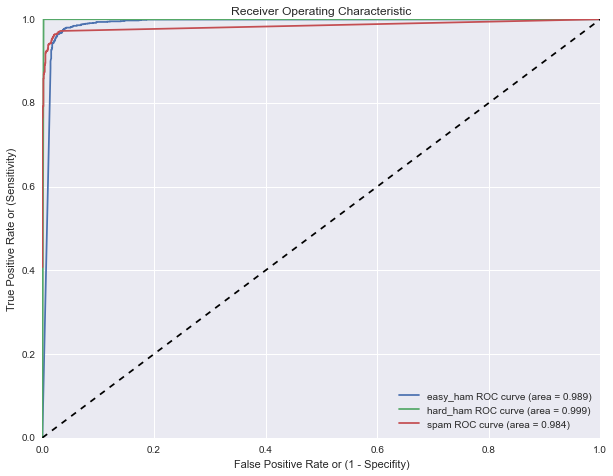

In [25]:
target_predicted_proba = modelNB.predict_proba(test_data2.data)
plot_roc_curve(test_data2.target, target_predicted_proba, test_data2.target_names)

On Your Own
========

1. Read the Naïve Bayes documentation at [scikit-learn.org](http://scikit-learn.org/stable/modules/naive_bayes.html). There are three Naïve Bayes classifiers described. Which of the other two might also be appropriate for this task?
2. Explain your choice and apply it to either the spam/ham dataset (if you completed the pair assignment) or the newsgroups dataset (if you didn't).
3. Use grid search cross validation to find the best parameters for both the vectorizor and classifier.
    - Do different parameters for the vectorizor work better for this classifier?
4. Does this classifier do better or worse than the multinomial classifier?
5. Advanced: consider the descriptions of the two classifiers in light of which does better for this problem. Can you posit a theory as to why one classifier should do better than the other?

##1. Read the Naïve Bayes documentation at [scikit-learn.org](http://scikit-learn.org/stable/modules/naive_bayes.html). There are three Naïve Bayes classifiers described. Which of the other two might also be appropriate for this task?


In [ ]:
#Bernouli
# From the docs:
# "In the case of text classification, word occurrence vectors (rather than word count vectors) 
# may be used to train and use this classifier. BernoulliNB might perform better on some datasets,
# especially those with shorter documents. It is advisable to evaluate both models, if time permits."

##2. Explain your choice and apply it to either the spam/ham dataset (if you completed the pair assignment) or the newsgroups dataset (if you didn't).


In [22]:
#re-using the data from above, with all three categories included

from sklearn.naive_bayes import BernoulliNB

pipeline2 = Pipeline((
    ('vec', TfidfVectorizer(preprocessor=strip_headers)),
    ('clf', BernoulliNB(binarize=0.0)),
))


##3. Use grid search cross validation to find the best parameters for both the vectorizor and classifier.
    - Do different parameters for the vectorizor work better for this classifier?


In [61]:
from sklearn.grid_search import GridSearchCV

parameters = {
    'vec__max_df': [0.8, 1.0],
    'vec__ngram_range': [(1, 1), (1,2)],
    'clf__alpha': np.logspace(-5, 0, 6)
}

gs = GridSearchCV(pipeline2, parameters, verbose=0, refit=False, n_jobs=1)
_ = gs.fit(train_data2.data, train_data2.target)

In [62]:
gs.best_score_

0.9458794587945879

In [63]:
gs.best_params_

{'clf__alpha': 1.0000000000000001e-05,
 'vec__max_df': 0.8,
 'vec__ngram_range': (1, 2)}

##4. Does this classifier do better or worse than the multinomial classifier?


In [23]:
#fit the bernoulli model with the ideal params
#using threshold of 0.0 to binarize features


pipeline2 = Pipeline((
    ('vec', TfidfVectorizer(max_df = 0.8, ngram_range = (1, 2), use_idf=True, preprocessor=strip_headers)),
    ('clf', BernoulliNB(alpha = 0.00001, binarize = 0.0)),
))

modelBB = pipeline2.fit(train_data2.data, train_data2.target)

In [24]:
#Try it against the test data


modelBB.score(test_data2.data, test_data2.target)

0.8592057761732852

##5. Advanced: consider the descriptions of the two classifiers in light of which does better for this problem. Can you posit a theory as to why one classifier should do better than the other?

In [ ]:
#multinomial might be performing better because we are solving a multi-class problem? 